# Environment setting

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import tensorflow as tf
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
import cv2 as cv
import pandas as pd
from protein_utils import TrainingHelper
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
import random
import os

In [2]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'
NUM_OF_CLASSES = 28
OPTIMIZERS = {
    "Adam" : tf.train.AdamOptimizer,
    "SGD" : tf.train.GradientDescentOptimizer,
    "RMS" : tf.train.RMSPropOptimizer
}

In [3]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.10.0


### Feature extraction functions

In [4]:
def extract_fn_train(data_record):
    features = {
        # Extract features using the keys set during creation
        'train/label': tf.FixedLenFeature((28), tf.int64),
        'train/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['train/image'] = tf.decode_raw(sample['train/image'], tf.float32)
    sample['train/image'] = tf.reshape(sample['train/image'], (512,512,3))
    sample['train/image'] = sample['train/image']/255
    
    return sample

def extract_fn_validation(data_record):
    features = {
        # Extract features using the keys set during creation
        'validation/label': tf.FixedLenFeature((28), tf.int64),
        'validation/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['validation/image'] = tf.decode_raw(sample['validation/image'], tf.float32)
    sample['validation/image'] = tf.reshape(sample['validation/image'], (512,512,3))
    sample['validation/image'] = sample['validation/image']/255

    return sample

def extract_fn_test(data_record):
    features = {
        'test/image': tf.FixedLenFeature([], tf.string)
    }    
    
    sample = tf.parse_single_example(data_record, features)
    sample['test/image'] = tf.decode_raw(sample['test/image'], tf.float32)
    sample['test/image'] = tf.reshape(sample['test/image'], (512,512,3))
    sample['test/image'] = sample['test/image']/255
    
    return sample

# Protein classifier model

In [5]:
class ProteinClassifier(tf.keras.Model):
    def __init__(self, optimizer="Adam", lr=1e-3):
        super().__init__()
        
        self.threshold = 0.5
        self.thresholds = np.zeros((28))
        self.thresholds += 0.5
        self.augment_step = 0
        self.augment_amount = 0
        
        # Block1B
        self.block1B_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block1B_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block2B
        self.block2B_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
              
        
        self.block2B_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block3B
        self.block3B_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block3B_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )       
        
        self.block3B_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                               )
        
        # Block4B
        self.block4B_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block4B_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )       
        
        self.block4B_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                               )
        
        # Block1_R
        self.block1R_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block1R_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block2R
        self.block2R_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
              
        
        self.block2R_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Block3R
        self.block3R_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block3R_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )       
        
        self.block3R_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                               )
        
        # Block4
        self.block4R_conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )
        
        self.block4R_conv2 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=[3, 3],
                                                strides=(1, 1),
                                                padding='same',
                                                use_bias=True,
                                                activation=tf.nn.relu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                               )       
        
        self.block4R_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                               )
        
        
        # Dense layers
        self.fc1B = tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.05))
        self.fc1R = tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.05))
        self.fc2 = tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.05))
        
        # Dropout layers
        self.dropout_conv = tf.keras.layers.Dropout(rate=0.3)
        self.dropout = tf.keras.layers.Dropout(rate=0.3)
    
        # Dense layer for classes
        self.fc3 = tf.keras.layers.Dense(NUM_OF_CLASSES)
                                         
        # Optimizers
        self.cross_entropy_optimizer = OPTIMIZERS[optimizer](learning_rate=lr)
        
    def preprocess_inputs(self, inputs):
        processes_inputs = np.zeros_like(inputs)
        processes_inputs[:,:,:,0] = (inputs[:,:,:,0] - mean_image_r)/std_image_r
        processes_inputs[:,:,:,1] = (inputs[:,:,:,1] - mean_image_g)/std_image_g
        processes_inputs[:,:,:,2] = (inputs[:,:,:,2] - mean_image_b)/std_image_b
        
        return processes_inputs
        
    def call(self, inputs_o, training=True, dropout=False, augment=False, augment_control=False, **kwargs):
        
        inputs = np.copy(inputs_o)
        
        if (augment):
            if augment_control:
                self.augment_step += 1
                for i in range(inputs.shape[0]):
                    flip_desicion = (self.augment_step % 4)
                    if (flip_desicion == 1):
                        inputs[i] = cv.flip(inputs[i], flip_desicion)
                    if (flip_desicion == 2):
                        inputs[i] = cv.flip(inputs[i], flip_desicion)
                    if (flip_desicion == 3):
                        inputs[i] = cv.flip(inputs[i], flip_desicion)
                    #shift_amount = int(500 / self.augment_amount) * self.augment_step
                    #inputs[i] = np.concatenate((inputs[i][shift_amount:,:,:], inputs[i][:shift_amount,:,:]), axis=0)
                    #shift_amount = int(500 / self.augment_amount) * self.augment_step
                    #inputs[i] = np.concatenate((inputs[i][:,shift_amount:,:], inputs[i][:,:shift_amount,:]), axis=1)
            else:
                for i in range(inputs.shape[0]):
                    flip_desicion = random.randint(0, 3)
                    if (flip_desicion == 1):
                        inputs[i] = cv.flip(inputs[i], 0)
                    if (flip_desicion == 2):
                        inputs[i] = cv.flip(inputs[i], 1)
                    if (flip_desicion == 3):
                        inputs[i] = cv.flip(inputs[i], -1)
                    if random.choice([True, True, False]):
                        shift_amount = random.randint(0,500)
                        inputs[i] = np.concatenate((inputs[i][shift_amount:,:,:], inputs[i][:shift_amount,:,:]), axis=0)
                    if random.choice([True, True, False]):
                        shift_amount = random.randint(0,500)
                        inputs[i] = np.concatenate((inputs[i][:,shift_amount:,:], inputs[i][:,:shift_amount,:]), axis=1)
                    if random.choice([False, False, False, True]):
                        mu, sigma = 0.5, 0.05
                        s = np.random.normal(mu, sigma, (60,60,3))
                        s = s.astype(np.float32)
                        rand_ver = random.randint(0,451)
                        rand_hor = random.randint(0,451)
                        inputs[i][rand_ver:rand_ver+60, rand_hor:rand_hor+60,:] = s
     
        
        # Input Layer
        input_r = inputs[:,:,:,0:1]
        input_g = inputs[:,:,:,1:2]
        input_b = inputs[:,:,:,2:]
        inputsR = np.concatenate((input_r,input_g), axis=3)
        inputsB = np.concatenate((input_b,input_g), axis=3)
        inputsR = tf.reshape(inputsR, [-1, 512, 512, 2])  
        inputsB = tf.reshape(inputsB, [-1, 512, 512, 2])  
        
        # Block1R
        x_1R = self.block1R_conv1(inputsR)
        x_1R = self.block1R_pool(x_1R)
        
        # Block2R
        x_2R = self.block2R_conv1(x_1R)
        x_2R = self.block2R_pool(x_2R)   
        
        # Block3R
        x_3R = self.block3R_conv1(x_2R)
        x_3R = self.block3R_conv2(x_3R)
        x_3R = self.block3R_pool(x_3R)
        
        # Block34R
        x_4R = self.block4R_conv1(x_3R)
        x_4R = self.block4R_conv2(x_4R)
        x_4R = self.block4R_pool(x_4R)
        
        x_4R = tf.reshape(x_4R, [x_4R.shape[0], -1])
        
        x_fcR = self.fc1R(x_4R)
        
        # Block1B
        x_1B = self.block1B_conv1(inputsB)
        x_1B = self.block1B_pool(x_1B)
        
        # Block2B
        x_2B = self.block2B_conv1(x_1B)
        x_2B = self.block2B_pool(x_2B)   
        
        # Block3B
        x_3B = self.block3B_conv1(x_2B)
        x_3B = self.block3B_conv2(x_3B)
        x_3B = self.block3B_pool(x_3B)
        
        # Block4B
        x_4B = self.block4B_conv1(x_3B)
        x_4B = self.block4B_conv2(x_4B)
        x_4B = self.block3B_pool(x_4B)
        
        x_4B = tf.reshape(x_4B, [x_4B.shape[0], -1])
        
        x_fcB = self.fc1B(x_4B)
        
        x_fc = tf.concat((x_fcR, x_fcB), axis=1)
        
        if (dropout):
            x_fc = self.dropout(x_fc)
            
        x_fc = self.fc2(x_fc)
        
        if (dropout):
            x_fc = self.dropout(x_fc)
        
            
        logits = self.fc3(x_fc)
        
        return logits

    def cross_entropy_loss(self, labels, logits):        
        labels_cast = tf.cast(labels, tf.float32)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_cast, logits=logits)
        cross_entropy_loss = tf.reduce_mean(loss)
        
        return cross_entropy_loss
    
    def f1_loss(self, labels, logits):        
        preds = self.get_normalized_logits(logits)
        f1_scores = self.calc_f1_scores(labels, preds, gather_relevant=True)
        f1_loss = 1 - f1_scores
        
        return f1_loss 

    def optimize(self, inputs, labels, training=True, dropout=False, augment=False, blur=False, loss_type='cross_entropy'):
        with tf.GradientTape(persistent=True) as tape:
            logits = self.get_logits(inputs, training=training, dropout=dropout, augment=augment, blur=blur)
        
            if loss_type=='cross_entropy':
                loss = self.cross_entropy_loss(labels, logits)

            else:
                loss = self.f1_loss(labels, logits)
        
        if training:
            gradients = tape.gradient(loss, self.variables)
            self.cross_entropy_optimizer.apply_gradients(zip(gradients, self.variables))

        del(tape)
        return loss
    
    def test(self, inputs, labels):
        predictions = self.predict_protein(inputs)
        f1_scores = self.calc_f1_scores(labels, predictions, gather_relevant=True)
                                        
        return f1_scores
    
    def calc_f1_scores(self, labels, predictions, gather_relevant=False):
        
        labels_cast = tf.cast(labels, tf.float32)
        relevant_labels = np.where(K.sum(labels_cast, axis=0))
        
        tp = K.sum(K.cast(labels_cast*predictions, 'float'), axis=0)
        tn = K.sum(K.cast((1-labels_cast)*(1-predictions), 'float'), axis=0)
        fp = K.sum(K.cast((1-labels_cast)*predictions, 'float'), axis=0)
        fn = K.sum(K.cast(labels_cast*(1-predictions), 'float'), axis=0)

        p = tp / (tp + fp + K.epsilon())
        r = tp / (tp + fn + K.epsilon())

        f1 = 2*p*r / (p+r+K.epsilon())

        f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
        if gather_relevant:
            f1 = tf.gather(f1, relevant_labels)

        f1 = tf.reduce_mean(f1)

        return f1
    
    def get_best_thresh(self, predictions, labels, save_threshold=False, step_size=0.005):
        thresholds = np.arange(0, 1, step_size)
        best_f1_score = 0
        best_thresh = 0
        for th in thresholds:
            under = np.where(np.array(predictions) < th)
            over = np.where(np.array(predictions) >= th)
            preds = np.array(predictions)
            preds[under] = 0
            preds[over] = 1
            prediction = tf.convert_to_tensor(preds, dtype=tf.float32)
            curr_f1_score = self.calc_f1_scores(labels, prediction)
            if (curr_f1_score > best_f1_score):
                best_f1_score = curr_f1_score
                best_thresh = th
                
        if (save_threshold):
            self.threshold = best_thresh
        
        
        return best_thresh, best_f1_score
    
    def get_best_thresholds(self, predictions, labels, save_threshold=False, step_size=0.005):
        thresholds = np.arange(0, 1, step_size)
        for i in range (self.thresholds.shape[0]):
            best_f1_score = 0
            for th in thresholds:
                prediction_check = np.zeros_like(predictions)
                prediction_check[:,i] = predictions[:,i]
                under = np.where(np.array(prediction_check) < th)
                over = np.where(np.array(prediction_check) >= th)
                zeros = np.where(np.array(prediction_check) == 0)
                preds = np.array(prediction_check)
                preds[under] = 0
                preds[over] = 1
                preds[zeros] = 0
                prediction = tf.convert_to_tensor(preds, dtype=tf.float32)
                curr_f1_score = self.calc_f1_scores(labels, prediction)
                if (curr_f1_score > best_f1_score):
                    best_f1_score = curr_f1_score
                    self.thresholds[i] = th

        return self.thresholds
        
        
    def get_logits(self, inputs, training=False, dropout=False, augment=False, blur=False, augment_control=False):
        logits = self(inputs, training=training, dropout=dropout, augment=augment, augment_control=augment_control)
        return logits

    def get_normalized_logits(self, logits):
        return tf.nn.sigmoid(logits)
    
    def predict_protein(self, inputs, debug_print=False):
        returned_prediction = np.zeros((int(inputs.shape[0]), 28))
        logits = self.get_logits(inputs)
        predictions = self.get_normalized_logits(logits).numpy()
        
        for i in range(int(inputs.shape[0])):
            
            over_condition = predictions[i] >= self.thresholds
            under_condtions = predictions[i] < self.thresholds
            if (np.all(under_condtions)):
                max_prediction = np.argmax(predictions[i])
                returned_prediction[i][max_prediction] = 1

            else:
                returned_prediction[i][over_condition] = 1
            

        if (debug_print):
            print("Class predictions: {}".format(np.where(returned_prediction==1)[0]))
            print("Probs: {}".format(predictions))

        return returned_prediction
    
    def predict_protein_augmented(self, inputs, num_of_augments=5, debug_print=False):
        self.augment_amount = num_of_augments
        self.augment_step = 0
        returned_prediction = np.zeros((int(inputs.shape[0]), 28))
        logits = np.zeros((num_of_augments, int(inputs.shape[0]), 28))
        logits[0] = self.get_logits(inputs)
        for aug_step in range(1, num_of_augments):
            logits[aug_step] = self.get_logits(inputs.numpy(), training=False, dropout=False, augment=True, blur=False, augment_control=True)
        
        predictions_normalized = tf.nn.sigmoid(logits)
        predictions = np.average(predictions_normalized, axis=0)
        
        for i in range(int(inputs.shape[0])):
            
            over_condition = predictions[i] >= self.thresholds
            under_condtions = predictions[i] < self.thresholds
        
            if (np.all(under_condtions)):
                max_prediction = np.argmax(predictions[i])
                returned_prediction[i][max_prediction] = 1
            else:
                returned_prediction[i][over_condition] = 1
            
        if (debug_print):
            print("Class predictions: {}".format(np.where(returned_prediction==1)[0]))
            print("Probs: {}".format(predictions))

        return returned_prediction, predictions

### Create 4 datasets, train, validation, test and mini dataset

In [6]:
list_of_test_tfrec = []
test_labels = pd.read_csv("sample_submission.csv")
num_of_test_images = test_labels.count()['Id']

for i in range(0, num_of_test_images):
    test_filename = 'data/tfrec/test/' + test_labels['Id'][i] + '.tfrec'
    list_of_test_tfrec.append(test_filename)

In [7]:
list_of_hpa_tfrec = os.listdir('data/tfrec/HPA')
list_of_hpa_tfrec = ['data/tfrec/HPA/' + file_name for file_name in list_of_hpa_tfrec]
random.shuffle(list_of_hpa_tfrec)
print(len(list_of_hpa_tfrec))

74606


In [8]:
list_of_rare = [8, 9, 10, 15, 27]
rare_examples = []
train_labels = pd.read_csv(TRAIN_PATH + "train.csv")
# Split training examples intot training and validation set
num_of_examples = train_labels.count()['Id']
num_train_set = int(num_of_examples * 0.85)
num_validation_set = num_of_examples - num_train_set
count=0
for i in range(0, int(num_train_set)): 
    train_filename = 'data/tfrec/train/' + train_labels['Id'][i] + '.tfrec'
    labels = np.zeros(shape=(NUM_OF_CLASSES), dtype=int)
    train_label = [int(s) for s in train_labels['Target'][i].split(' ')]
    for label in train_label:
        if label in list_of_rare:
            rare_examples.append(train_filename)
list_of_train_tfrec = os.listdir('data/tfrec/train')
list_of_train_tfrec = ['data/tfrec/train/' + file_name for file_name in list_of_train_tfrec]
for i in range(9):
    list_of_train_tfrec = list_of_train_tfrec + rare_examples
list_of_train_tfrec = list_of_train_tfrec + list_of_hpa_tfrec
random.shuffle(list_of_train_tfrec)

In [9]:
num_epochs_test = 1
batch_size_test = 16
submission_dataset = tf.data.TFRecordDataset(list_of_test_tfrec)
submission_dataset = submission_dataset.map(extract_fn_test)
submission_dataset = submission_dataset.batch(batch_size_test)

list_of_validation_tfrec = os.listdir('data/tfrec/validation')
list_of_validation_tfrec = ['data/tfrec/validation/' + file_name for file_name in list_of_validation_tfrec]
num_epochs_val = 1
batch_size_val = 16
val_dataset = tf.data.TFRecordDataset(list_of_validation_tfrec)
val_dataset = val_dataset.map(extract_fn_validation)
val_dataset = val_dataset.batch(batch_size_val)


num_epochs = 30
batch_size = 16
buffer_size = 300
train_dataset = tf.data.TFRecordDataset(list_of_train_tfrec)
train_dataset = train_dataset.map(extract_fn_train)
train_dataset = train_dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size, num_epochs))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.apply(tf.contrib.data.prefetch_to_device("/device:GPU:0"))

num_epochs_mini = 10
batch_size_mini = 16
buffer_size_mini = 80
mini_dataset = tf.data.TFRecordDataset(list_of_train_tfrec[0:320])
mini_dataset = mini_dataset.map(extract_fn_train)
mini_dataset = mini_dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size_mini, num_epochs_mini))
mini_dataset = mini_dataset.batch(batch_size_mini)
mini_dataset = mini_dataset.apply(tf.contrib.data.prefetch_to_device("/device:GPU:0"))

# Training

### Training on mini dataset to make sure model over fits and choose LR accordingly

[19.12|23:00:09] Step 0: training loss: 0.692989
[19.12|23:00:09] Step 0: training F1 score: 0.118519
[19.12|23:02:17] Step 100: training loss: 0.113436
[19.12|23:02:17] Step 100: training F1 score: 0.203526


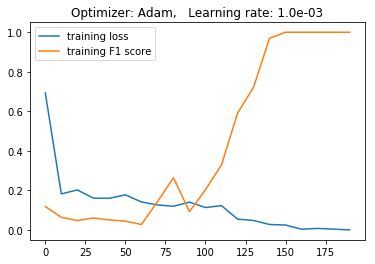

[19.12|23:04:27] Step 0: training loss: 0.691556
[19.12|23:04:27] Step 0: training F1 score: 0.000000
[19.12|23:06:36] Step 100: training loss: 0.123639
[19.12|23:06:36] Step 100: training F1 score: 0.103387


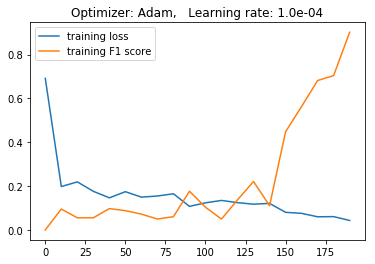

[19.12|23:08:46] Step 0: training loss: 0.690007
[19.12|23:08:46] Step 0: training F1 score: 0.065972
[19.12|23:10:55] Step 100: training loss: 0.129045
[19.12|23:10:55] Step 100: training F1 score: 0.054545


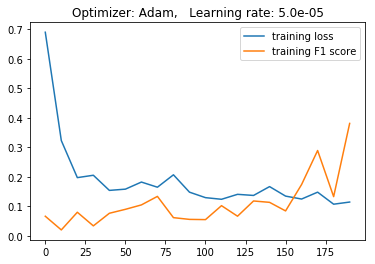

[19.12|23:13:05] Step 0: training loss: 0.692746
[19.12|23:13:05] Step 0: training F1 score: 0.174000


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [10]:
lrs = [1e-3, 1e-4, 0.5e-4, 1e-5]
for lr in lrs:
    model = ProteinClassifier(lr=lr)
    model_helper = TrainingHelper(step_size=10, 
                    y_value_names=["training loss", "training F1 score"])
    itr = mini_dataset.make_one_shot_iterator()

    try:
        for step, x in enumerate(itr):
            with tf.device("/device:GPU:0"):
                loss = model.optimize(x['train/image'].numpy(), x['train/label'],training=True, dropout=False, augment=False, blur=False)
                train_score = model.test(x['train/image'], x['train/label'])
                if step % 100 == 0:
                    model_helper.append_outputs_if_required({"training loss" : loss,
                                                            "training F1 score" : train_score},
                                                                    curr_step=step, print_output=True)
                else:
                    model_helper.append_outputs_if_required({"training loss" : loss,
                                                            "training F1 score" : train_score},
                                                                    curr_step=step, print_output=False)
        model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % ("Adam", lr),
                     keys_to_print=["training loss", "training F1 score"])
    except Exception as err:
        raise
    finally:
        pass

In [10]:
best_score = 0
global_step = 0

model = ProteinClassifier(lr=1e-3)
model_helper = TrainingHelper(step_size=50, 
                y_value_names=["training loss", "training F1 score", "validation score"])
model.load_weights('cpt/cpt_4_no_pre_aug_RB.weights')
itr = train_dataset.make_one_shot_iterator()

try:
    for step, x in enumerate(itr):
        with tf.device("/device:GPU:0"):
            loss = model.optimize(x['train/image'].numpy(), x['train/label'],training=True, dropout=True, augment=True, blur=False)
            model_helper.append_outputs_if_required({"training loss" : loss},
                                                            curr_step=step+global_step, print_output=False)
            if ((step % 1000 == 0) or (step % 6388 == 0)):
                predictions = None
                labels = None
                val_itr = val_dataset.make_one_shot_iterator()
                for step_val, x_val in enumerate(val_itr):
                    curr_prediction = model.predict_protein(x_val['validation/image'])
                    if predictions is not None:
                        predictions = np.concatenate((predictions, curr_prediction), axis=0)
                        labels = np.concatenate((labels, x_val['validation/label'].numpy()))
                    else:
                        predictions = curr_prediction
                        labels = x_val['validation/label'].numpy()
                val_score = model.calc_f1_scores(labels, predictions)
                train_score = model.test(x['train/image'], x['train/label'])
                if ((step % 6388 == 0) and (step != 0)):
                    print("End of epoch {} results:".format(int(step/6388)))
                model_helper.append_outputs_if_required({"training loss" : loss, "training F1 score" : train_score,
                                                         "validation score" : val_score}, curr_step=step+global_step, print_output=True)
        if (step % 50 == 0):
            if (val_score > best_score):
                best_score = val_score
                model.save_weights('cpt/cpt_4_no_pre_aug_RB.weights')

except Exception as err:
    raise
finally:
    pass

<Figure size 432x288 with 0 Axes>

In [30]:
with open('log') as f:
    content = f.readlines()
model_helper = TrainingHelper(step_size=50, 
                y_value_names=["training loss", "training F1 score", "validation score"])    
for i, line in enumerate(content):
    line_split = line.split()
    num = float(line_split[-1])
    word = line_split[-2]
    if (word == 'loss:'):
        model_helper.y_dict['training loss'].append(num)
        model_helper.x['training loss'].append(int(i/3)*1000)
    elif (len(line_split) == 7):
        model_helper.y_dict['training F1 score'].append(num)
        model_helper.x['training F1 score'].append(int(i/3)*1000)
    else:
        model_helper.y_dict['validation score'].append(num)
        model_helper.x['validation score'].append(int(i/3)*1000)
        

<Figure size 432x288 with 0 Axes>

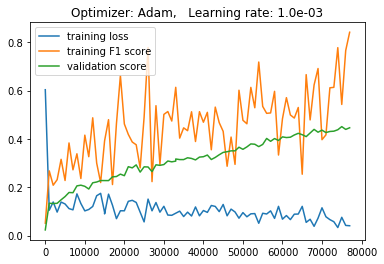

In [31]:
model_helper.show_graph(title="Optimizer: %s,   Learning rate: %.1e" % ("Adam", 1e-3),
                     keys_to_print=["training loss", "training F1 score", "validation score"])

# Evaluation on validation set

### Get best thresh (for all classes) 

In [16]:
predictions = None
labels = None
test_model = ProteinClassifier()
test_model.load_weights('cpt/cpt_4_no_pre_w_aug_RB.weights')
with tf.device("/device:GPU:0"):
    predictions = None
    labels = None
    val_itr = val_dataset.make_one_shot_iterator()
    for step_val, x_val in enumerate(val_itr):
        logits = test_model.get_logits(x_val['validation/image'])
        curr_prediction = test_model.get_normalized_logits(logits).numpy()
        if predictions is not None:
            predictions = np.concatenate((predictions, curr_prediction), axis=0)
            labels = np.concatenate((labels, x_val['validation/label'].numpy()))
        else:
            predictions = curr_prediction
            labels = x_val['validation/label'].numpy()

In [17]:
print(test_model.get_best_thresh(predictions, labels, save_threshold=False, step_size=0.0005))

(0.5710000000000001, <tf.Tensor: id=143689, shape=(), dtype=float32, numpy=0.4727456>)


### Get best thresh based on entire dataset

In [40]:
num_epochs_val = 1
batch_size_val = 16
val_dataset = tf.data.TFRecordDataset(list_of_validation_tfrec)
val_dataset = val_dataset.map(extract_fn_validation)
val_dataset = val_dataset.batch(batch_size_val)
val_dataset = val_dataset.apply(tf.contrib.data.prefetch_to_device("/device:GPU:0"))


num_epochs = 1
batch_size = 16
train_dataset = tf.data.TFRecordDataset(list_of_train_tfrec)
train_dataset = train_dataset.map(extract_fn_train)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.apply(tf.contrib.data.prefetch_to_device("/device:GPU:0"))

In [42]:
predictions = None
labels = None
test_model = ProteinClassifier()
test_model.load_weights('cpt/cpt_4_no_pre_w_aug_RB.weights')
with tf.device("/device:GPU:0"):
    val_itr = val_dataset.make_one_shot_iterator()
    for step_val, x_val in enumerate(val_itr):
        if (step_val % 50 == 0):
            print("Reached {} out of {} steps".format(step_val, 292))
        _, curr_prediction = test_model.predict_protein_augmented(x_val['validation/image'], num_of_augments=4)
        if predictions is not None:
            predictions = np.concatenate((predictions, curr_prediction), axis=0)
            labels = np.concatenate((labels, x_val['validation/label'].numpy()))
        else:
            predictions = curr_prediction
            labels = x_val['validation/label'].numpy()

    train_itr = train_dataset.make_one_shot_iterator()
    for step_train, x_train in enumerate(train_itr):
        if (step_train % 50 == 0):
            print("Reached {} out of {} steps".format(step_train, 1725))
        _, curr_prediction = test_model.predict_protein_augmented(x_train['train/image'], num_of_augments=4)
        if predictions is not None:
            predictions = np.concatenate((predictions, curr_prediction), axis=0)
            labels = np.concatenate((labels, x_train['train/label'].numpy()))
        else:
            predictions = curr_prediction
            labels = x_train['train/label'].numpy()

Reached 0 out of 292 steps
Reached 50 out of 292 steps
Reached 100 out of 292 steps
Reached 150 out of 292 steps
Reached 200 out of 292 steps
Reached 250 out of 292 steps
Reached 0 out of 1725 steps
Reached 50 out of 1725 steps
Reached 100 out of 1725 steps
Reached 150 out of 1725 steps
Reached 200 out of 1725 steps
Reached 250 out of 1725 steps
Reached 300 out of 1725 steps
Reached 350 out of 1725 steps
Reached 400 out of 1725 steps
Reached 450 out of 1725 steps
Reached 500 out of 1725 steps
Reached 550 out of 1725 steps
Reached 600 out of 1725 steps
Reached 650 out of 1725 steps
Reached 700 out of 1725 steps
Reached 750 out of 1725 steps
Reached 800 out of 1725 steps
Reached 850 out of 1725 steps
Reached 900 out of 1725 steps
Reached 950 out of 1725 steps
Reached 1000 out of 1725 steps
Reached 1050 out of 1725 steps
Reached 1200 out of 1725 steps
Reached 1250 out of 1725 steps
Reached 1300 out of 1725 steps
Reached 1350 out of 1725 steps
Reached 1400 out of 1725 steps
Reached 1450 ou

KeyboardInterrupt: 

In [45]:
print(test_model.get_best_thresholds(predictions, labels, save_threshold=False, step_size=0.01))

[0.22 0.79 0.78 0.22 0.82 0.23 0.23 0.21 0.23 0.23 0.22 0.22 0.82 0.89
 0.82 0.19 0.59 0.69 0.37 0.22 0.96 0.22 0.74 0.78 0.8  0.21 0.76 0.75]


In [10]:
threshs = np.array([0.13, 0.52, 0.66, 0.67, 0.27, 0.53, 0.59, 0.56, 0.41, 0.8, 0.56, 0.56, 0.77, 0.83,
 0.53 0.   0.48 0.22 0.55 0.75 0.98 0.27 0.78 0.35 0.98 0.26 0.51 0.15])

In [31]:
threshs

array([0.43, 0.3 , 0.4 , 0.32, 0.33, 0.35, 0.25, 0.37, 0.27, 0.48, 0.47,
       0.3 , 0.22, 0.21, 0.27, 0.18, 0.22, 0.16, 0.18, 0.3 , 0.21, 0.31,
       0.22, 0.41, 0.24, 0.34, 0.22, 0.46])

### Test on validation set based on multiple thresholds with test augmentation

In [18]:
predictions = None
labels = None
test_model = ProteinClassifier()
test_model.load_weights('cpt/cpt_4_no_pre_w_aug_RB.weights')
with tf.device("/device:GPU:0"):
    predictions = None
    labels = None
    val_itr = val_dataset.make_one_shot_iterator()
    for step_val, x_val in enumerate(val_itr):
        if (step_val % 30 == 0):
            print("Reached {} out of {} steps".format(step_val, 292))
        curr_prediction, _ = test_model.predict_protein_augmented(x_val['validation/image'], num_of_augments=1)
        if predictions is not None:
            predictions = np.concatenate((predictions, curr_prediction), axis=0)
            labels = np.concatenate((labels, x_val['validation/label'].numpy()))
        else:
            predictions = curr_prediction
            labels = x_val['validation/label'].numpy()

Reached 0 out of 292 steps
Reached 30 out of 292 steps
Reached 60 out of 292 steps
Reached 90 out of 292 steps
Reached 120 out of 292 steps
Reached 150 out of 292 steps
Reached 180 out of 292 steps
Reached 210 out of 292 steps
Reached 240 out of 292 steps
Reached 270 out of 292 steps


In [19]:
print(test_model.calc_f1_scores(labels, predictions))
print(f1_score(labels, predictions, average='macro'))

tf.Tensor(0.4696731, shape=(), dtype=float32)
0.4696731268670777


# Test set prediction

In [14]:
test_model.thresholds

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5])

In [29]:
test_model = ProteinClassifier()
test_model.load_weights('cpt/cpt_4_no_pre_aug_RB.weights')
protein_prediction = np.zeros((11702, 28))
test_model.thresholds -= 0.25
i = 0
pos = 0
with tf.device("/device:GPU:0"):
    val_itr = submission_dataset.make_one_shot_iterator()
    for val_step, val_x in enumerate(val_itr):
        if (val_step % 30 == 0):
            print("reached {} out of {}".format(val_step, 732))
        curr_prediction = test_model.predict_protein(val_x['test/image'])
        protein_prediction[pos:pos+int(curr_prediction.shape[0])] = curr_prediction[0:int(curr_prediction.shape[0])]
        pos += int(curr_prediction.shape[0])
    
#submission = pd.read_csv("sample_submission.csv")
#submission_copy = submission.copy()
#for i in range(11702):
#    proteins = np.where(np.array(protein_prediction[i]) == 1)[0].tolist()
#    guess = " ".join(str(x) for x in proteins[::-1])
#    submission_copy.loc[i,'Predicted'] = guess

#submission_copy.to_csv("submission_1.csv", index=False)

reached 0 out of 732
reached 30 out of 732
reached 60 out of 732
reached 90 out of 732
reached 120 out of 732
reached 150 out of 732
reached 180 out of 732
reached 210 out of 732
reached 240 out of 732
reached 270 out of 732
reached 300 out of 732
reached 330 out of 732
reached 360 out of 732
reached 390 out of 732
reached 420 out of 732
reached 450 out of 732
reached 480 out of 732
reached 510 out of 732
reached 540 out of 732
reached 570 out of 732
reached 600 out of 732
reached 630 out of 732
reached 660 out of 732
reached 690 out of 732
reached 720 out of 732


In [30]:
c0, c1, c2, c3, c4, c5 = 0, 0, 0, 0, 0, 0
for i in range(protein_prediction.shape[0]):
    if (len(np.where(protein_prediction[i] == 1)[0]) == 0):
        c0+=1
    if (len(np.where(protein_prediction[i] == 1)[0]) == 1):
        c1+=1
    if (len(np.where(protein_prediction[i] == 1)[0]) == 2):
        c2+=1
    if (len(np.where(protein_prediction[i] == 1)[0]) == 3):
        c3+=1
    if (len(np.where(protein_prediction[i] == 1)[0]) == 4):
        c4+=1
    if (len(np.where(protein_prediction[i] == 1)[0]) == 5):
        c5+=1
print(c0, c1, c2, c3, c4, c5, c1+c2+c3+c4+c5)

0 4771 4768 1783 322 48 11692


In [31]:
submission = pd.read_csv("sample_submission.csv")
submission_copy = submission.copy()
for i in range(11702):
    proteins = np.where(np.array(protein_prediction[i]) == 1)[0].tolist()
    guess = " ".join(str(x) for x in proteins[::-1])
    submission_copy.loc[i,'Predicted'] = guess

submission_copy.to_csv("submission_1.csv", index=False)

In [32]:
submission_copy.head

<bound method NDFrame.head of                                          Id  Predicted
0      00008af0-bad0-11e8-b2b8-ac1f6b6435d0        2 0
1      0000a892-bacf-11e8-b2b8-ac1f6b6435d0         25
2      0006faa6-bac7-11e8-b2b7-ac1f6b6435d0    25 21 0
3      0008baca-bad7-11e8-b2b9-ac1f6b6435d0       25 0
4      000cce7e-bad4-11e8-b2b8-ac1f6b6435d0         25
5      00109f6a-bac8-11e8-b2b7-ac1f6b6435d0       25 4
6      001765de-bacd-11e8-b2b8-ac1f6b6435d0     25 4 0
7      0018641a-bac9-11e8-b2b8-ac1f6b6435d0          0
8      00200f22-bad7-11e8-b2b9-ac1f6b6435d0          0
9      0026f154-bac6-11e8-b2b7-ac1f6b6435d0    25 14 2
10     002729d2-bace-11e8-b2b8-ac1f6b6435d0         25
11     002c1a7c-bad4-11e8-b2b8-ac1f6b6435d0          5
12     003170fa-bacd-11e8-b2b8-ac1f6b6435d0       25 2
13     0031820a-baca-11e8-b2b8-ac1f6b6435d0          7
14     00407c16-bad3-11e8-b2b8-ac1f6b6435d0         21
15     005ce2ea-bacc-11e8-b2b8-ac1f6b6435d0         23
16     00631ec8-bad9-11e8-b2b9-ac1f